# Modelling

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import umap
from hdbscan import HDBSCAN

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import shap

In [2]:
# read csv
df = pd.read_csv("twitter_bots_final.csv")

### Prepare data for modelling

BERTopic on `description_en` and combine with other features

Empty descriptions: 13341
Percentage of total: 35.63%


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitl


Train Topic Proportions (%):
-1     32.23
 0     35.80
 1      9.05
 2      6.08
 3      3.54
 4      2.74
 5      2.62
 6      2.21
 7      1.99
 8      0.97
 9      0.88
 10     0.64
 11     0.28
 12     0.22
 13     0.22
 14     0.17
 15     0.10
 16     0.10
 17     0.09
 18     0.05
Name: topic, dtype: float64


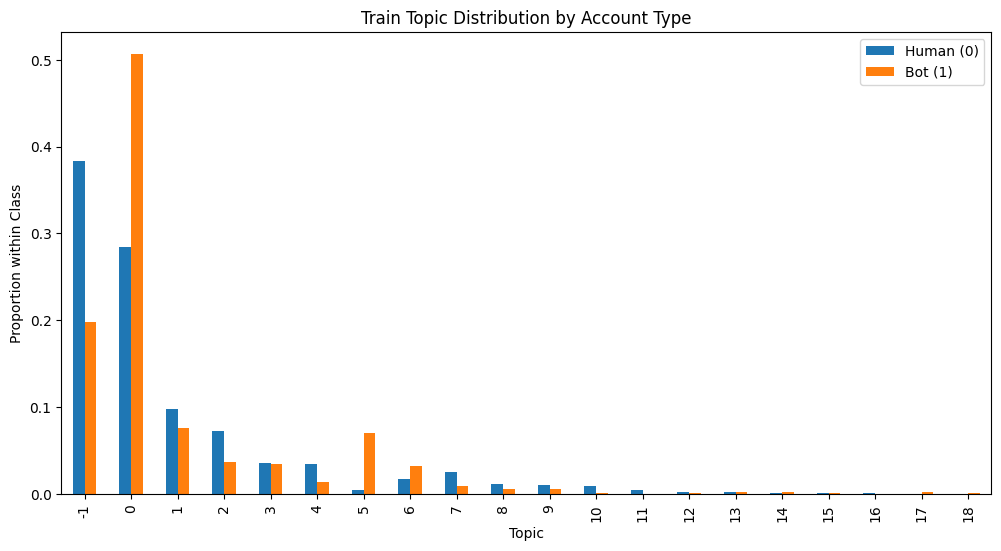


Top Topics:
   Topic  Count                                               Name  \
0     -1   9652                                -1_love_life_im_mom   
1      0  10722  0_missing_description_missing_description miss...   
2      1   2711                   1_translationtext_twitter_im_bot   
3      2   1822                     2_music_artist_writer_designer   
4      3   1061                             3_love_life_dream_live   
5      4    820                4_husband_father_husband father_dad   
6      5    784                              5_come_like_want_site   
7      6    661          6_trading_stock_day trading_trading stock   
8      7    597                  7_news_journalist_reporter_editor   
9      8    292                             8_coffee_dog_mom_lover   

                                      Representation  \
0  [love, life, im, mom, lover, world, fan, write...   
1  [missing_description, missing_description miss...   
2  [translationtext, twitter, im, bot, official,

In [3]:
# drop unused columns 
df_bert = df.drop(columns=['description', 'description_en_embeddings']).copy()

# check empty descriptions
empty_count = df_bert['description_en'].isna().sum()
print(f"Empty descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")

# replace empty descriptions with placeholder
df_bert['description_en'] = df_bert['description_en'].fillna("missing_description")

# convert to binary
df_bert['account_type'] = df_bert['account_type'].map({'bot': 1, 'human': 0})

# train/test 80/20
train_df, test_df  = train_test_split(df_bert, test_size=0.2, stratify=df_bert['account_type'], random_state=42)

# tabular features
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols  = ['lang', 'description_language']
num_cols  = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]

# booleans to int
for col in bool_cols:
    train_df[col] = train_df[col].astype(int)
    test_df[col]  = test_df[col].astype(int)

# one-hot encode categoricals
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=False)
test_df  = pd.get_dummies(test_df, columns=cat_cols, drop_first=False)
test_df  = test_df.reindex(columns=train_df.columns, fill_value=0)

# scale numeric features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols]  = scaler.transform(test_df[num_cols])

# define BERTopic model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # English

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words='english')

nr_topics = 20

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",
    nr_topics=nr_topics,
    top_n_words=10
)

# fit BERTopic model on train set 
train_texts = train_df['description_en'].tolist()
topics_train, probs_train = topic_model.fit_transform(train_texts)

# transform test set
test_texts  = test_df['description_en'].tolist()
topics_test, probs_test = topic_model.transform(test_texts)

# add topics to DataFrames
train_df['topic'] = topics_train
test_df['topic']  = topics_test

# visualise performance
topic_counts = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts*100).round(2))

# topic proportions by account_type
topic_by_label = train_df.groupby(['account_type','topic']).size().unstack(fill_value=0)
topic_by_label = topic_by_label.div(topic_by_label.sum(axis=1), axis=0)
topic_by_label.T.plot(kind="bar", figsize=(12,6))
plt.title("Train Topic Distribution by Account Type")
plt.ylabel("Proportion within Class")
plt.xlabel("Topic")
plt.legend([f"{label} ({i})" for i, label in enumerate(["Human", "Bot"])])
plt.show()

# look at top topics
topic_info = topic_model.get_topic_info()
print("\nTop Topics:")
print(topic_info.head(10))

# create feature matrices 

# one-hot encode topics
topic_dummies_train = pd.get_dummies(train_df['topic'].astype(str), prefix='topic')
topic_dummies_test  = pd.get_dummies(test_df['topic'].astype(str), prefix='topic')

# align columns
topic_dummies_test = topic_dummies_test.reindex(columns=topic_dummies_train.columns, fill_value=0)

# tabular features
tabular_cols = [c for c in train_df.columns if c not in ['description_en', 'topic', 'account_type']]

X_train_bert = np.hstack([topic_dummies_train.values, train_df[tabular_cols].values])
X_test_bert  = np.hstack([topic_dummies_test.values, test_df[tabular_cols].values])

y_train_bert = train_df['account_type'].values
y_test_bert  = test_df['account_type'].values

print("X_train_bert shape:", X_train_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)

Check topic distribution in train and test sets

In [4]:
# check topic distribution between train and test
topic_counts_train = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts_train * 100).round(2))

topic_counts_test = test_df['topic'].value_counts(normalize=True).sort_index()
print("\nTest Topic Proportions (%):")
print((topic_counts_test * 100).round(2))


Train Topic Proportions (%):
-1     32.23
 0     35.80
 1      9.05
 2      6.08
 3      3.54
 4      2.74
 5      2.62
 6      2.21
 7      1.99
 8      0.97
 9      0.88
 10     0.64
 11     0.28
 12     0.22
 13     0.22
 14     0.17
 15     0.10
 16     0.10
 17     0.09
 18     0.05
Name: topic, dtype: float64

Test Topic Proportions (%):
-1     35.98
 0     35.07
 1      7.85
 2      6.09
 3      2.95
 4      2.32
 5      2.88
 6      1.86
 7      1.60
 8      0.80
 9      0.76
 10     0.79
 11     0.47
 12     0.15
 13     0.17
 14     0.08
 15     0.04
 16     0.04
 17     0.07
 18     0.03
Name: topic, dtype: float64


Visualise top words for each topic

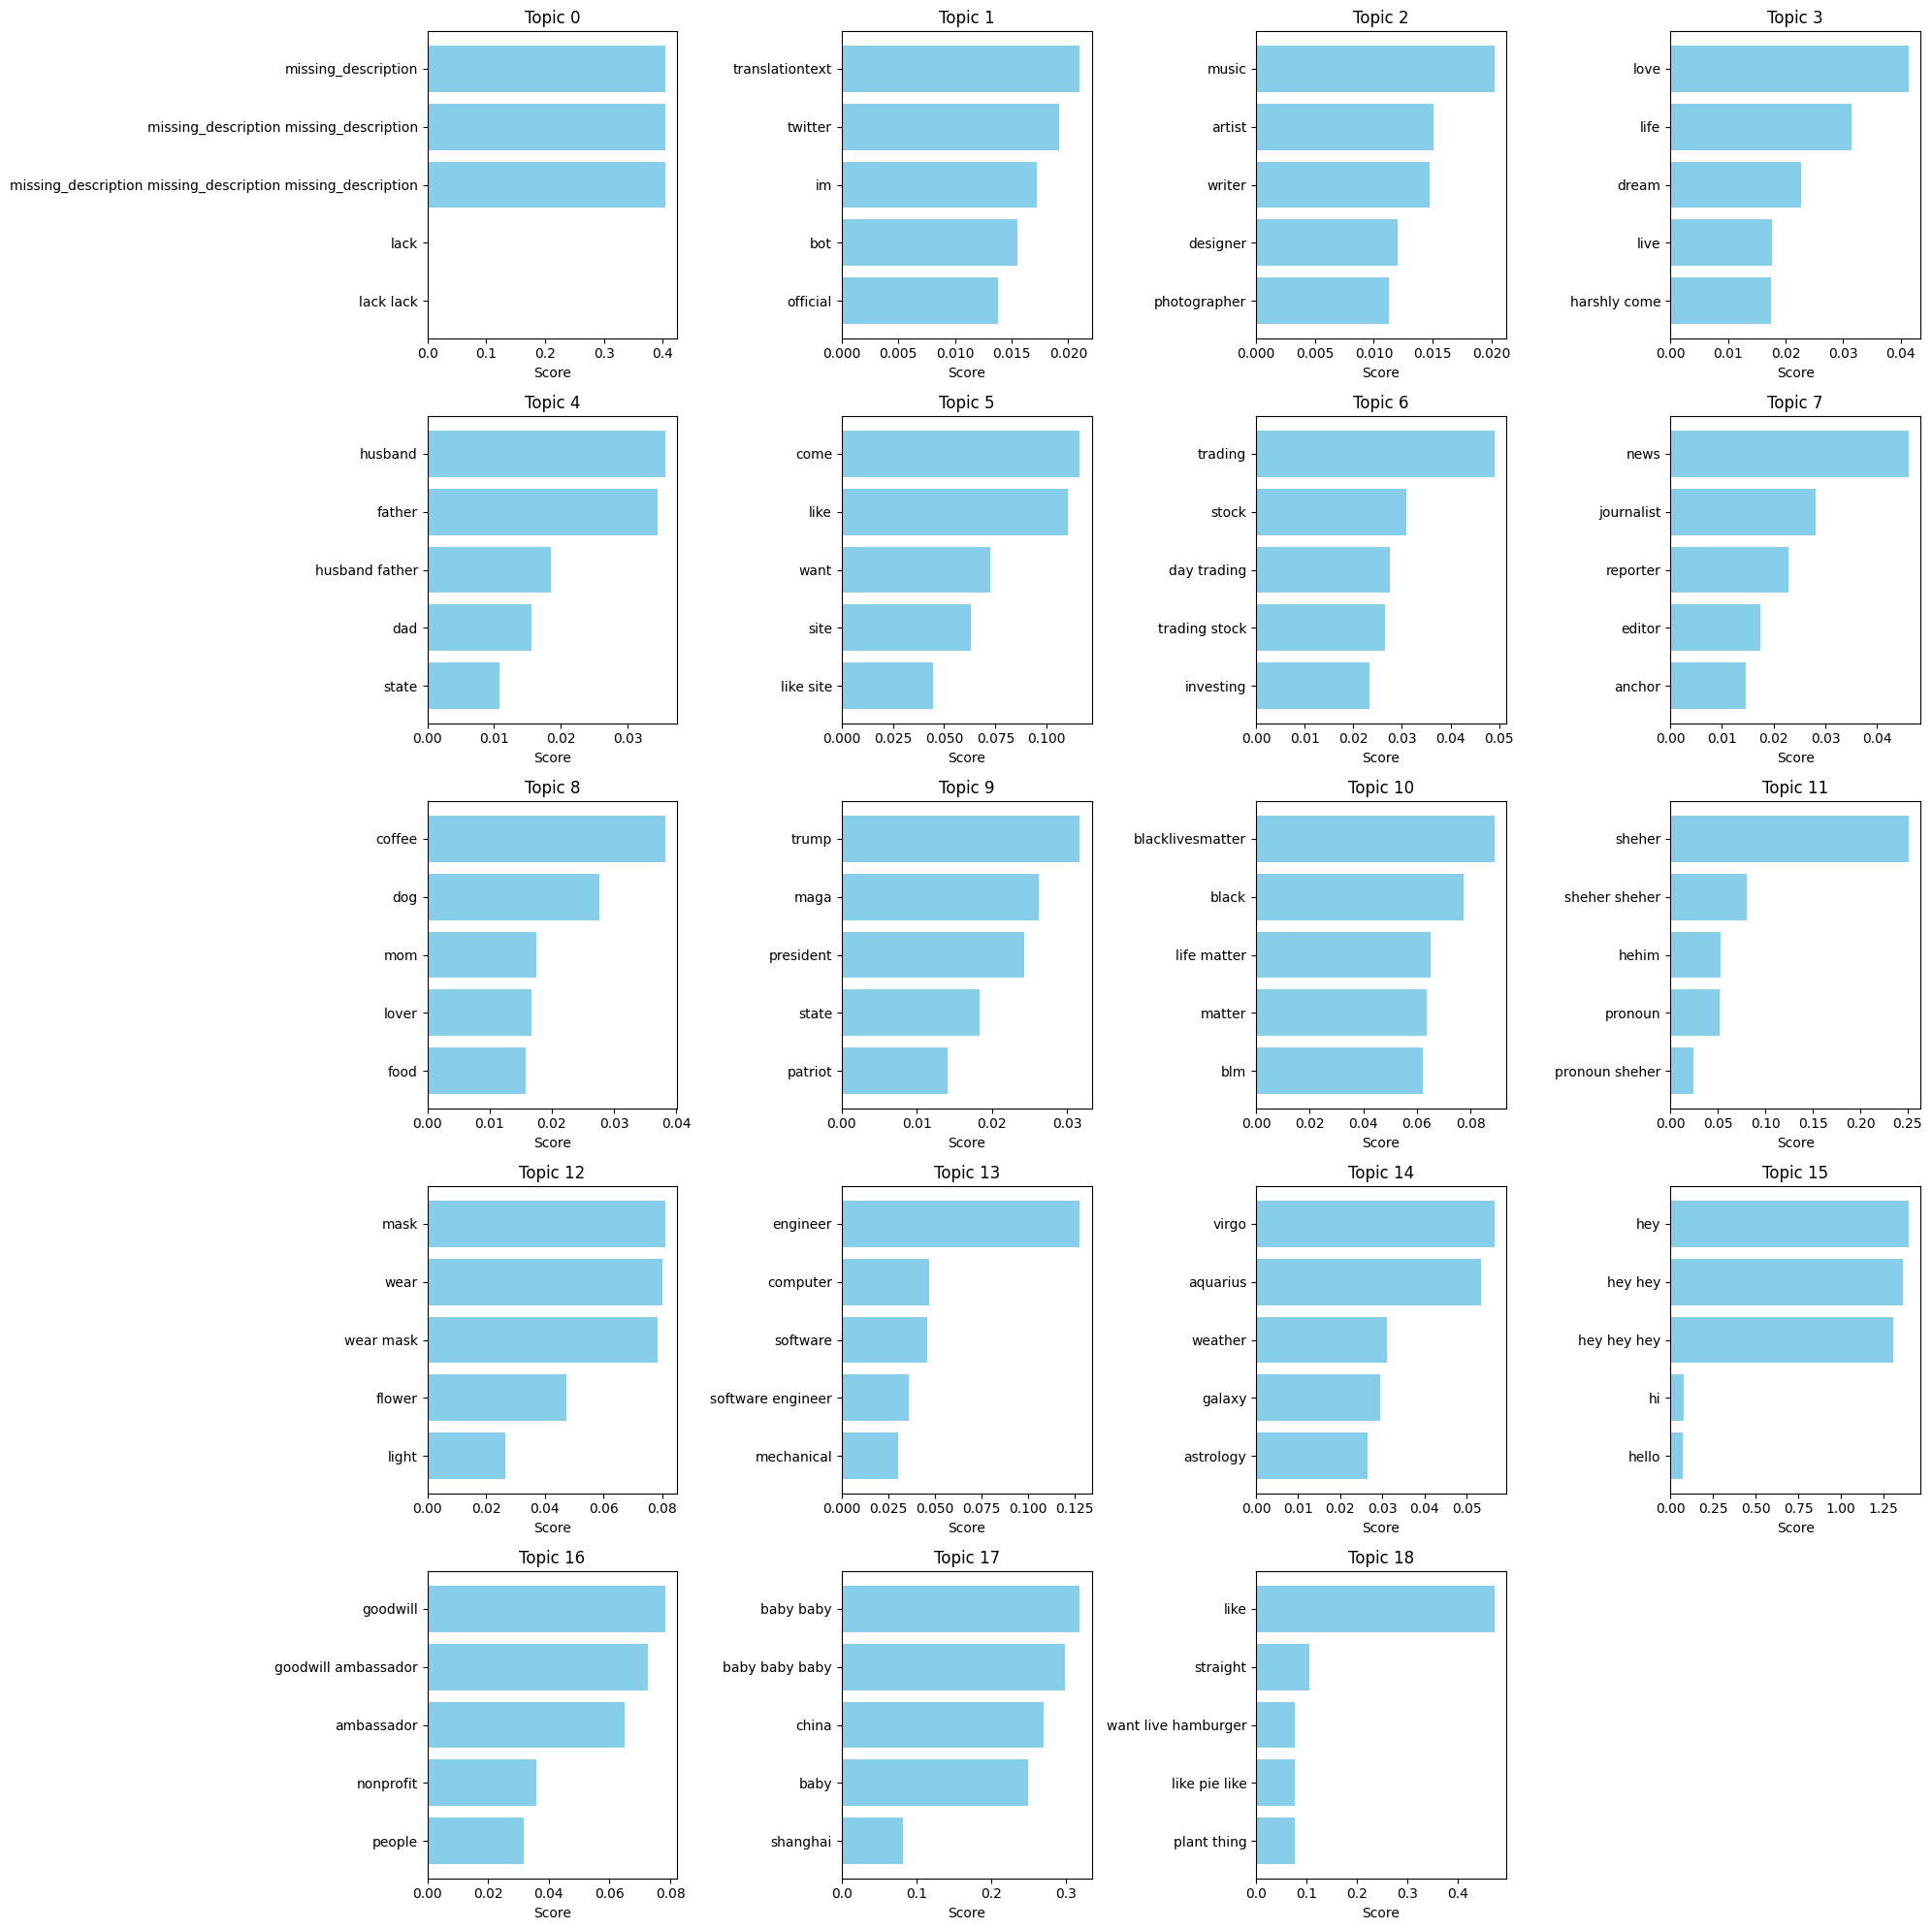

In [5]:
top_n_words = 5  # number of top words to show
topics = topic_model.get_topics()
topics_to_plot = [tid for tid in topics.keys() if tid != -1]  # skip -1

# grid size: 4 plots per row
n_cols = 4
n_rows = math.ceil(len(topics_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # flatten in case of multiple rows

for i, topic_id in enumerate(topics_to_plot):
    words_scores = topics[topic_id][:top_n_words]
    words, scores = zip(*words_scores)
    axes[i].barh(words, scores, color='skyblue')
    axes[i].set_title(f"Topic {topic_id}")
    axes[i].invert_yaxis()  # highest score on top
    axes[i].set_xlabel("Score")

# hide any unused subplots if number of topics is not divisible by n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Check for data leakage

In [6]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train_bert)
test_df = pd.DataFrame(X_test_bert)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


In [7]:
# convert to DataFrames for comparison
train_check = pd.DataFrame(X_train_bert)
test_check = pd.DataFrame(X_test_bert)

# find overlapping rows
overlap = pd.merge(train_check, test_check, how='inner')

if len(overlap) > 0:
    print(f"{len(overlap)} overlapping samples found between train and test sets!")
else:
    print("No overlap detected between train and test sets.")

No overlap detected between train and test sets.


### Baseline Model

#### Baseline Model: Logistic Regression

In [8]:
# initialise Logistic Regression
lr_bert = LogisticRegression(max_iter=1000, class_weight='balanced')

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(lr_bert, X_train_bert, y_train_bert, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate on train CV
print("LR Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("LR Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
lr_bert.fit(X_train_bert, y_train_bert)

LR Train CV Accuracy: 0.7524874791318865
LR Train CV ROC-AUC: 0.8434347715478276
              precision    recall  f1-score   support

           0       0.88      0.72      0.80     20010
           1       0.59      0.81      0.68      9940

    accuracy                           0.75     29950
   macro avg       0.74      0.77      0.74     29950
weighted avg       0.79      0.75      0.76     29950



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [9]:
# predict on test set
y_test_pred = lr_bert.predict(X_test_bert)
y_test_prob = lr_bert.predict_proba(X_test_bert)[:, 1]

# evaluate on test set
print("LR Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("LR Test AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

LR Test Accuracy: 0.750801282051282
LR Test AUC: 0.8439206898396174
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      5003
           1       0.59      0.79      0.68      2485

    accuracy                           0.75      7488
   macro avg       0.73      0.76      0.74      7488
weighted avg       0.78      0.75      0.76      7488



##### Features Evaluation: Logistic Regresssion

Top features for Logistic Regression:
       feature  importance
26    verified    2.457176
15     topic_5    2.157635
60     lang_mk    1.917922
82  lang_zh-cn    1.835027
4     topic_11    1.789317
68     lang_ru    1.536320
3     topic_10    1.383047
53     lang_hu    1.324612
57     lang_ko    1.306912
10    topic_17    1.259861


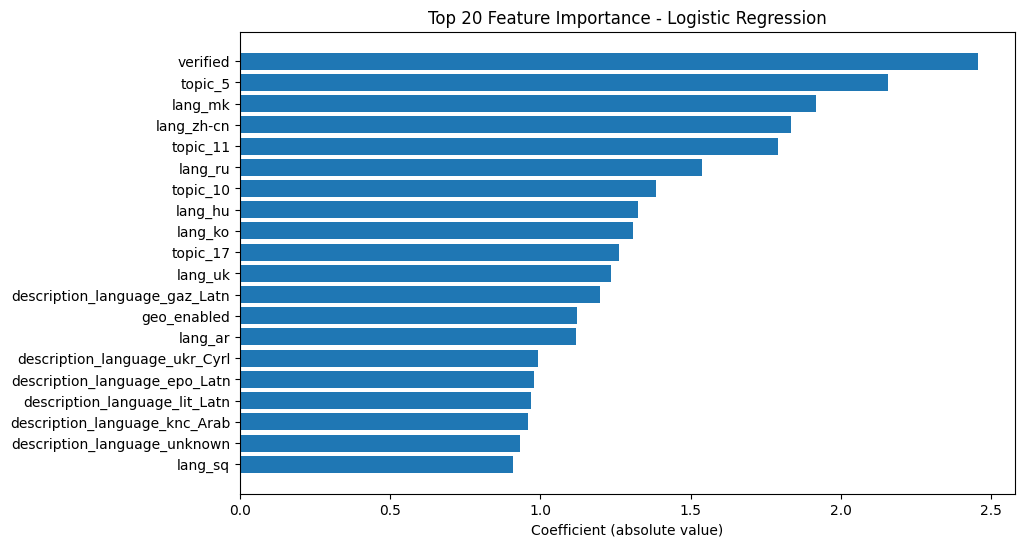

In [10]:
# feature names (topic + tabular)
feature_names = topic_dummies_train.columns.tolist() + tabular_cols

# coefficients
lr_coef = lr_bert.coef_[0]  # binary classification

# LR feature importance
lr_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(lr_coef)
}).sort_values(by='importance', ascending=False)

print("Top features for Logistic Regression:")
print(lr_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(lr_feat_importance['feature'].head(20), lr_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Logistic Regression")
plt.xlabel("Coefficient (absolute value)")
plt.show()

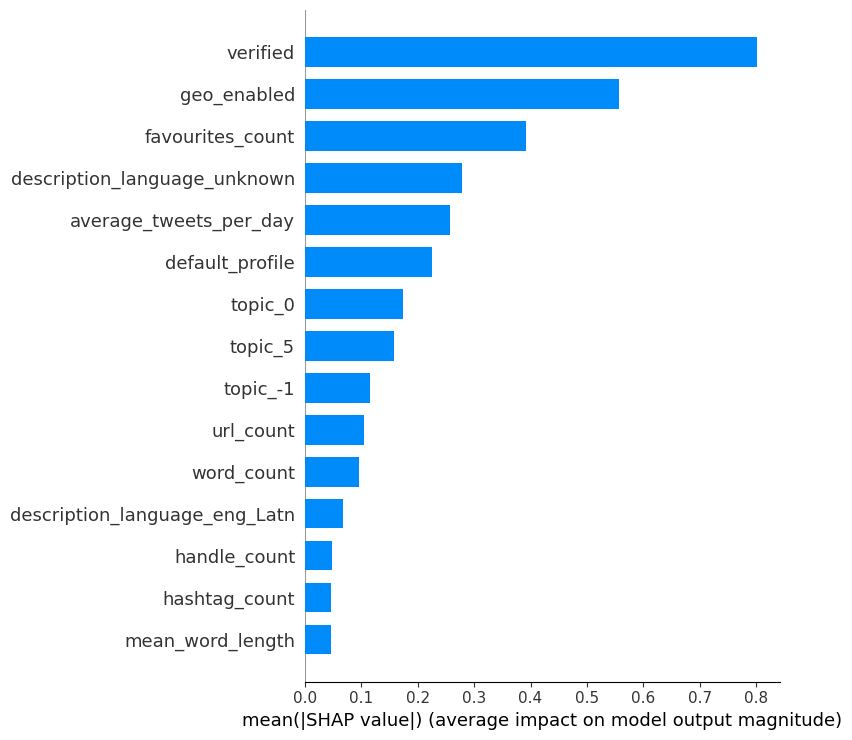

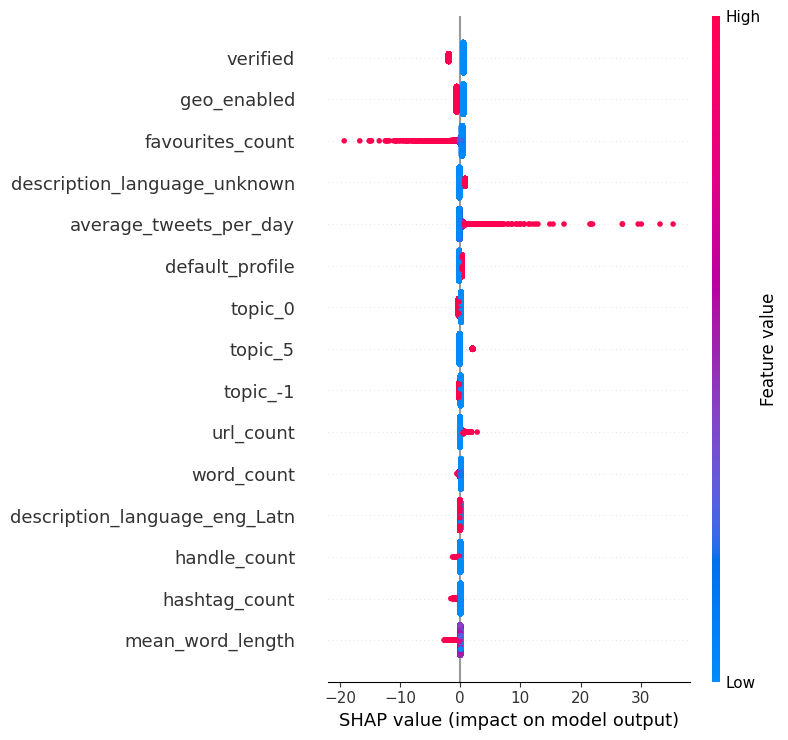

In [11]:
explainer_lr = shap.LinearExplainer(lr_bert, X_train_bert, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_train_bert)

# Summary plot
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, plot_type="bar", max_display=15)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, max_display=15)

#### Baseline Model: Decision Tree

In [12]:
# initialise model
dt_bert = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(dt_bert, X_train_bert, y_train_bert, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate CV performance on train
print("DT Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("DT Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
dt_bert.fit(X_train_bert, y_train_bert)


DT Train CV Accuracy: 0.822237061769616
DT Train CV ROC-AUC: 0.7999595524169505
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     20010
           1       0.73      0.73      0.73      9940

    accuracy                           0.82     29950
   macro avg       0.80      0.80      0.80     29950
weighted avg       0.82      0.82      0.82     29950



,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [13]:
# predict on test set
y_test_pred = dt_bert.predict(X_test_bert)
y_test_prob = dt_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set performance
print("DT Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("DT Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

DT Test Accuracy: 0.828926282051282
DT Test ROC-AUC: 0.8069632667079832
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5003
           1       0.74      0.74      0.74      2485

    accuracy                           0.83      7488
   macro avg       0.81      0.81      0.81      7488
weighted avg       0.83      0.83      0.83      7488



##### Features Evaluation: Decision Tree

Top features for Decision Tree:
                        feature  importance
23              followers_count    0.336761
22             favourites_count    0.125401
27       average_tweets_per_day    0.106073
28             account_age_days    0.099520
24                friends_count    0.096200
34  log_followers_friends_ratio    0.047180
30             mean_word_length    0.030730
29                   word_count    0.024534
26                     verified    0.023266
25                  geo_enabled    0.012783


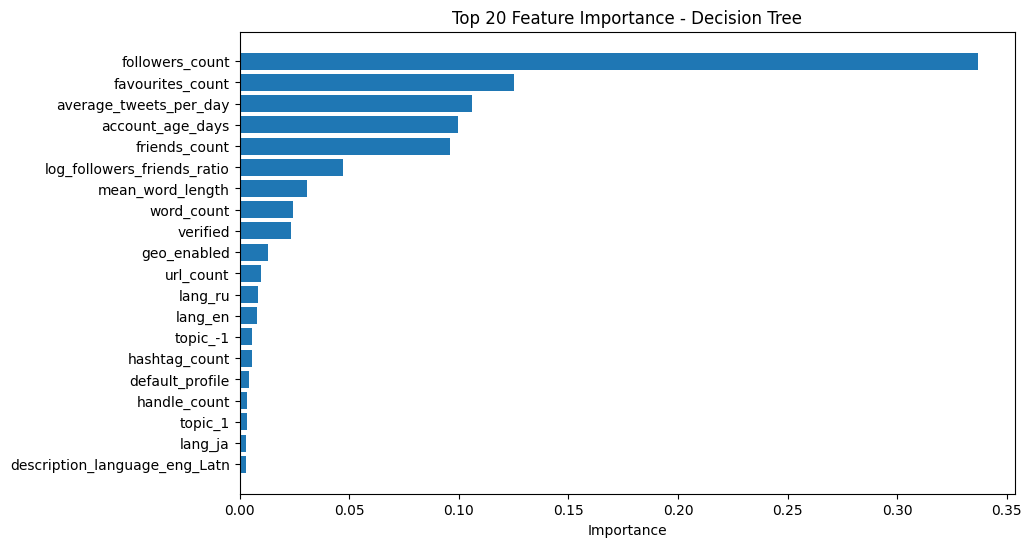

In [14]:
# feature importance
dt_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Decision Tree:")
print(dt_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(dt_feat_importance['feature'].head(20), dt_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.show()

In [15]:
X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

explainer_dt = shap.TreeExplainer(dt_bert)
shap_values_dt = explainer_dt.shap_values(X_train_df)

print(type(shap_values_dt))
if isinstance(shap_values_dt, list):
    print([s.shape for s in shap_values_dt])
else:
    print(shap_values_dt.shape)
print("X_train_df shape:", X_train_df.shape)

<class 'numpy.ndarray'>
(29950, 212, 2)
X_train_df shape: (29950, 212)


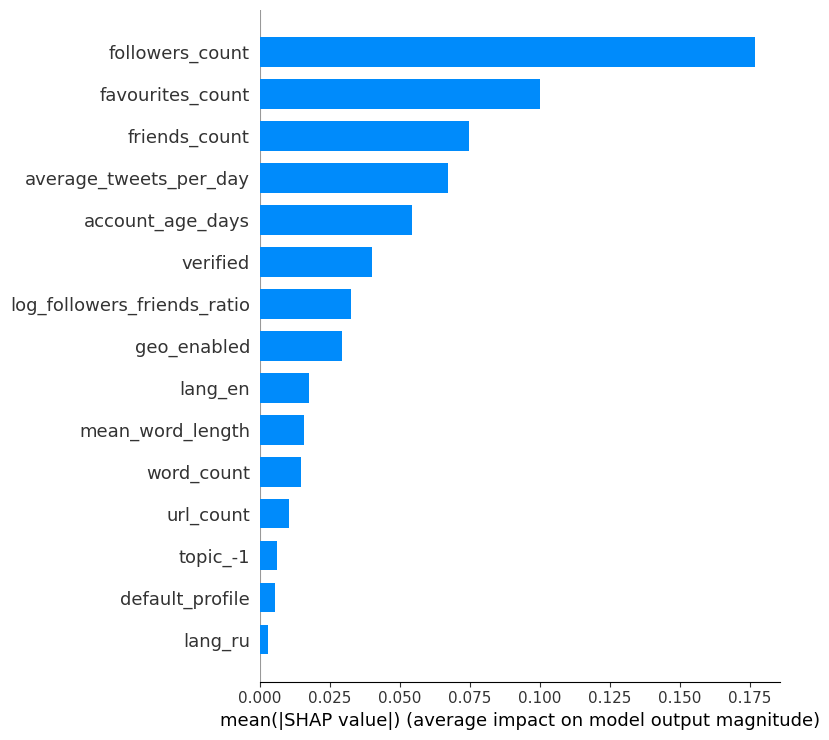

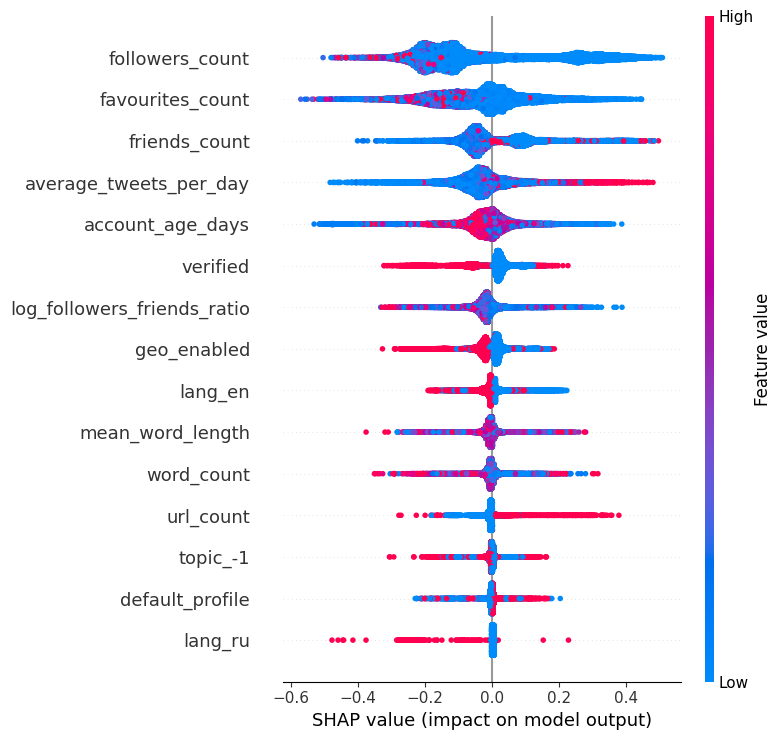

In [16]:
shap_values_class1 = shap_values_dt[:, :, 1]

# Bar summary plot
shap.summary_plot(shap_values_class1, X_train_df, plot_type="bar", max_display=15)
shap.summary_plot(shap_values_class1, X_train_df, max_display=15)

#### Baseline Model: Random Forest

In [17]:
# initialise RF model
rf_bert = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(
    rf_bert,
    X_train_bert,
    y_train_bert,
    cv=cv,
    method='predict_proba'
)[:, 1]

y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate CV performance on train
print("RF Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("RF Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
rf_bert.fit(X_train_bert, y_train_bert)


RF Train CV Accuracy: 0.8698831385642738
RF Train CV ROC-AUC: 0.9284731728703053
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     20010
           1       0.86      0.72      0.79      9940

    accuracy                           0.87     29950
   macro avg       0.87      0.83      0.85     29950
weighted avg       0.87      0.87      0.87     29950



,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
# predict on test set
y_test_pred = rf_bert.predict(X_test_bert)
y_test_prob = rf_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set
print("RF Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("RF Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))


RF Test Accuracy: 0.8699252136752137
RF Test ROC-AUC: 0.9297839002835724
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      5003
           1       0.86      0.72      0.79      2485

    accuracy                           0.87      7488
   macro avg       0.87      0.83      0.85      7488
weighted avg       0.87      0.87      0.87      7488



##### Features Evaluation: Random Forest

Top features for Random Forest:
                        feature  importance
23              followers_count    0.149634
22             favourites_count    0.133771
24                friends_count    0.119128
27       average_tweets_per_day    0.099845
28             account_age_days    0.082269
34  log_followers_friends_ratio    0.081785
30             mean_word_length    0.048938
25                  geo_enabled    0.038308
29                   word_count    0.037848
26                     verified    0.033804


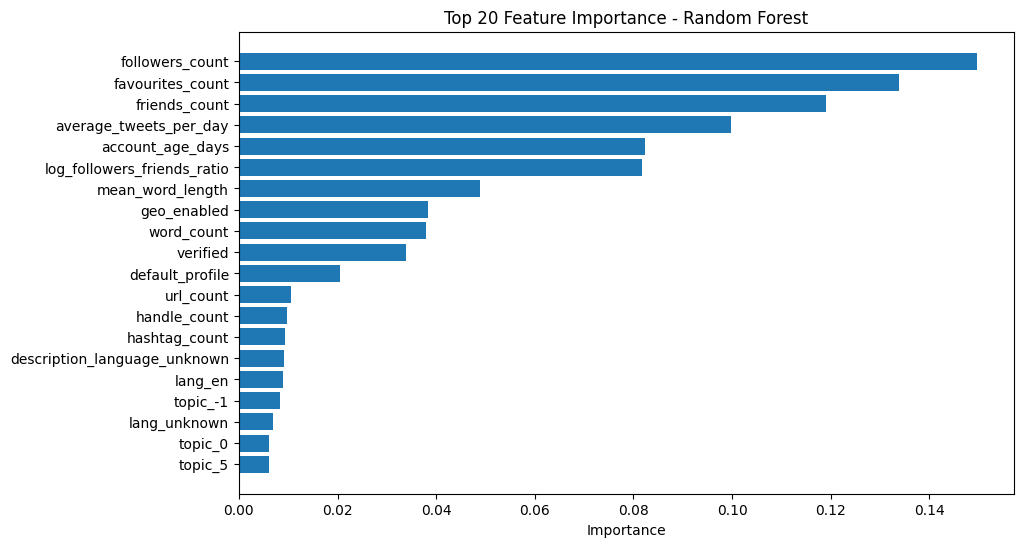

In [19]:
# RF feature importance
rf_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Random Forest:")
print(rf_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(rf_feat_importance['feature'].head(20), rf_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.show()

In [20]:
# X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

# explainer_rf = shap.TreeExplainer(rf_bert)
# shap_values_rf = explainer_rf.shap_values(X_train_df)

# print(type(shap_values_rf))
# print(np.array(shap_values_rf).shape)

# shap_values_rf_class1 = shap_values_rf[:, :, 1]

# shap.summary_plot(shap_values_rf_class1, X_train_df, plot_type="bar", max_display=15)
# shap.summary_plot(shap_values_rf_class1, X_train_df, max_display=15)

### Model 1

### Model 2